In [1]:
import torch
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [2]:
def get_mnist_biased(batch_size, data_root, bias_portion):
    print('Building Biased Mnist dataloader...')
    ds = []
    train_dataset = datasets.MNIST(root=data_root, train=True, download=True,
                                    transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms. Normalize((0.1307,),(0.3081,)) 
                                    ]))   #得到原始Mnist数据集
    sampler = get_bin_sampler(train_dataset.targets, bias_portion) 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    ds.append(train_loader)

    test_dataset = datasets.MNIST(root=data_root, train=False, download=True,
                                    transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms. Normalize((0.1307,),(0.3081,)) 
                                    ]))   #得到原始Mnist数据集
    sampler = get_bin_sampler(test_dataset.targets, bias_portion) 
    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=sampler)
    ds.append(test_loader)
    # ds = ds[0] if len(ds) == 1 else ds
    return ds

In [3]:
def get_bin_sampler(targets, bias_portion):
    # 根据dataset的标签数据来获取给dataloader按权重装载数据所需的sampler
    # bias_number为想要改变采样比例的0-9的数字，bias_portion为1-99的数，标志这个数字占总样本数的百分比
    class_count = torch.tensor(
        [(targets == t).sum() for t in torch.unique(targets, sorted=True)]) # 统计0 1两个class的样本总数
    class_weights = (class_count[0]+class_count[1])/class_count # 取样本数倒数作为权重，可使每个class的采样概率均等
    class_weights[0] *= bias_portion / (100-bias_portion) # 将改变的class的权重放大
    for i in range(2, 10):
        class_weights[i] = 0
    sample_weights = torch.tensor([class_weights[t] for t in targets])
    sampler = WeightedRandomSampler(sample_weights, len(targets))
    return sampler

In [4]:
def test_data():    
    train_loader, test_loader = get_mnist_biased(batch_size=1, data_root='data', bias_portion=80)
    print(len(train_loader))
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 8, 5
    for batch_idx, (data, target) in enumerate(train_loader):
        figure.add_subplot(rows, cols, batch_idx+1)
        plt.title(target.numpy())
        plt.axis("off")
        plt.imshow(data.squeeze(), cmap="gray")
        if batch_idx >= 39:
            break
    plt.show()

Building Biased Mnist dataloader...
60000


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


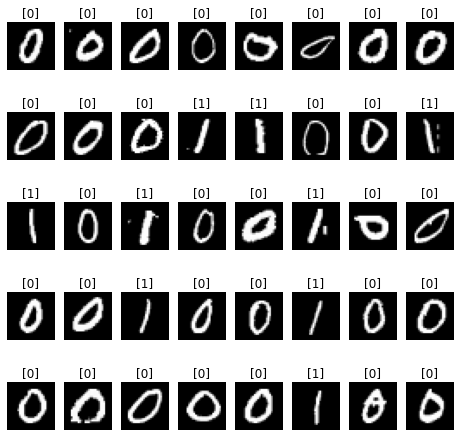

In [5]:
test_data()